[View in Colaboratory](https://colab.research.google.com/github/brynmwangy/predicting-bitcoin-prices-using-LSTM/blob/master/btc.ipynb)

In [1]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline


In [2]:
#we now define the network
#Hyperparameters used in the network
batch_size = 10 #how many windows of data we are passing at once
window_size_en = 1 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 # How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 10
training_test_blocks=5
plot_period='Week'

In [3]:
#decoding the files as uploaded will be a dictionary of keys (the file names) and values (the encoded file objects)
# eu = pd.read_csv('./us_euro_daily_exrate.csv')
eu = pd.read_csv('./us_euro_daily_exrate.csv', parse_dates=[0])

In [75]:
#selecting only the column that we are going to use in the prediction process

#data_to_use=btc['Value'].values
# eu = eu[~eu['Value'].isnull()]
# forward fill value
# data_df = eu[~eu['Value'].isnull()]

eu =  eu.fillna(method='ffill')
data_df = eu
eu_rates = data_df['Value'].astype(float)
# eu_rates = eu['Value'].astype(float)
data_to_use=eu_rates.values
data_to_use
len(data_to_use)

4934

In [76]:
# eu_weekly = data_df.groupby([data_df.index, data_df['Date'].dt.strftime('%W'), data_df['Date'].dt.strftime('%Y')])['Value'].mean()
eu_time_line = pd.DataFrame(eu.groupby([eu.index, eu['Date'].dt.strftime('%W')])['Value'].mean())
eu_time_line = eu_time_line.reset_index('Date')
eu_time_line['Year']= eu['Date'].dt.strftime('%Y')
eu_time_line = eu_time_line.rename(columns={'Date':'Week'})
eu_time_line['Month']= eu['Date'].dt.strftime('%m')
eu_time_line = eu_time_line.rename(columns={'Date':'Month'})


In [77]:
eu_day_value_line = eu_time_line[['Year', 'Week', 'Value']]
eu_day_value_line['Dayofweek'] = eu['Date'].dt.dayofweek


In [78]:
gb=eu_day_value_line.groupby(['Year', 'Week', 'Dayofweek'])['Value'].max()

In [79]:
# eu_dv_df = pd.DataFrame(gb).reset_index()


In [137]:
#mf_df = eu_day_value_line[(eu_day_value_line['Dayofweek'] == 0) | (eu_day_value_line['Dayofweek'] == 4)]
mon_df = eu_day_value_line[(eu_day_value_line['Dayofweek'] == 0)]
tue_df = eu_day_value_line[(eu_day_value_line['Dayofweek'] == 1)]
wed_df = eu_day_value_line[(eu_day_value_line['Dayofweek'] == 2)]
thu_df = eu_day_value_line[(eu_day_value_line['Dayofweek'] == 3)]
fri_df = eu_day_value_line[(eu_day_value_line['Dayofweek'] == 4)]

In [138]:
fri_df.shape, mon_df.shape, tue_df.shape, wed_df.shape

((987, 4), (986, 4), (987, 4), (987, 4))

In [139]:
# #fri_df.drop()
# fri_df = fri_df.drop(fri_df.index[fri_df.shape[0]-1]) 
# tue_df = tue_df.drop(tue_df.index[tue_df.shape[0]-1])
# wed_df = wed_df.drop(wed_df.index[wed_df.shape[0]-1])
# thu_df = thu_df.drop(thu_df.index[thu_df.shape[0]-1])

fri_df = fri_df.drop(fri_df.index[0]) 
tue_df = tue_df.drop(tue_df.index[0])
wed_df = wed_df.drop(wed_df.index[0])
thu_df = thu_df.drop(thu_df.index[0])
fri_j_df = fri_df.drop(fri_df.index[fri_df.shape[0]-1]) 

In [189]:
mon_c_df = (mon_df['Value'] - fri_df['Value'].values) / mon_df['Value']*100
tue_c_df = (tue_df['Value'] - mon_df['Value'].values) / tue_df['Value']*100
wed_c_df = (wed_df['Value'] - tue_df['Value'].values) / wed_df['Value']*100
thu_c_df = (thu_df['Value'] - wed_df['Value'].values) / thu_df['Value']*100
fri_c_df = (fri_df['Value'] - thu_df['Value'].values) / fri_df['Value']*100
# fri_c_df = (fri_df['Value'] - mon_df['Value'].values) / fri_df['Value']*100

type(m_f_df)

pandas.core.series.Series

Text(0.5, 1.0, 'Friday')

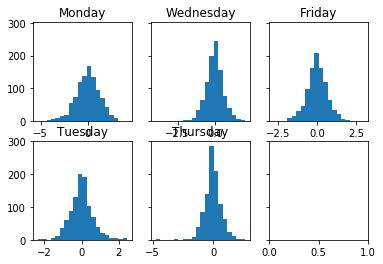

In [219]:
# fig, axes = plt.subplots(3, 2, sharey=True)
# axes[0,0].hist(mon_c_df, bins=20)
# axes[0,0].set_title("Monday")
# axes[0,1].hist(tue_c_df, bins=20)
# axes[0,1].set_title("Tuesday")
# axes[1,0].hist(wed_c_df, bins=20)
# axes[1,0].set_title("Wednesday")
# axes[1,1].hist(thu_c_df, bins=20)
# axes[1,1].set_title("Thursday")
# axes[2,0].hist(fri_c_df, bins=20)
# axes[2,0].set_title("Friday")

fig, axes = plt.subplots(2, 3, sharey=True)
axes[0,0].hist(mon_c_df, bins=20)
axes[0,0].set_title("Monday")
axes[1,0].hist(tue_c_df, bins=20)
axes[1,0].set_title("Tuesday")
axes[0,1].hist(wed_c_df, bins=20)
axes[0,1].set_title("Wednesday")
axes[1,1].hist(thu_c_df, bins=20)
axes[1,1].set_title("Thursday")
axes[0,2].hist(fri_c_df, bins=20)
axes[0,2].set_title("Friday")


In [220]:
sd_gp

[0.13164728075261498,
 0.13175284186226702,
 0.13182412844921118,
 0.13185030528893385,
 0.13152878289051287]

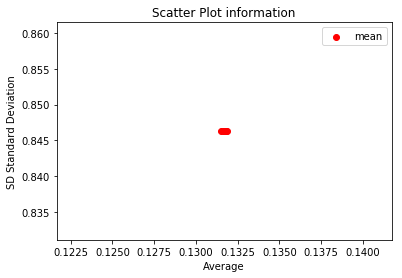

In [221]:
mon_sd = np.std(mon_df['Value'])
tue_sd = np.std(tue_df['Value'])
wed_sd = np.std(wed_df['Value'])
thu_sd = np.std(thu_df['Value'])
fri_sd = np.std(fri_df['Value'])

mon_m = np.mean(mon_df['Value'])
tue_m = np.mean(tue_df['Value'])
wed_m = np.mean(wed_df['Value'])
thu_m = np.mean(thu_df['Value'])
fri_m = np.mean(fri_df['Value'])

mean_gp = [mon_m, tue_m, wed_m, thu_m, fri_m]
sd_gp = [mon_sd, tue_sd, wed_sd, thu_sd, fri_sd]
# a = [2,4,6,8,10,12,14,16]
# b = [1,1.5,2,2.5,3,3.5,4,4.5]
# ab=[8,8.5,9,9.5,10,10.5,11]
# cd=[3,3.5,3.7,4,4.5,5,5.2]
# plt.scatter(a,b,label='mean',color='r')
# plt.scatter(ab,cd,label='SD',color='b')
plt.scatter(sd_gp, mean_gp, label='mean',color='r')
plt.xlabel('Average')
plt.ylabel('SD Standard Deviation')
plt.title('Scatter Plot information')
plt.legend()
plt.show()


In [222]:
eu_df = pd.DataFrame((eu_time_line.groupby(['Year', plot_period]).mean())).reset_index(plot_period)

In [75]:
eu_df.columns


Index(['Week', 'Value'], dtype='object')

In [76]:
eu_df['Rate Change']=eu_df['Value'].diff(periods=1)
eu_df.head()

,Week,Value,Rate Change
Year,,,
1999,01,0.85572,NaN
1999,02,0.86120,0.00548
1999,03,0.86310,0.00190
1999,04,0.87128,0.00818
1999,05,0.88404,0.01276


In [77]:
rate_change_df = pd.DataFrame()
rate_change_df['Rate Change']=eu_df['Value'].diff(periods=1)*100/eu_df['Value']

In [78]:
rate_change_df = rate_change_df.fillna(0)
rate_change_to_use = rate_change_df.values

In [79]:
data_df = eu_df[~eu_df['Value'].isnull()]
eu_rates = data_df['Value'].astype(float)
# eu_rates = eu['Value'].astype(float)
data_to_use=eu_rates.values
data_to_use
len(data_to_use)

995

In [80]:
len(data_to_use)

995

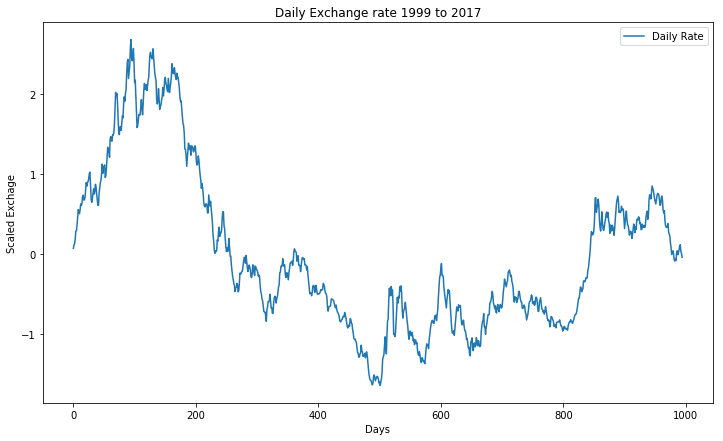

In [81]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))
# scaled_rate_change_data = scaler.fit_transform(rate_change_to_use.reshape(-1,1))

#plotting the data
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Daily Exchange rate 1999 to 2017')
plt.xlabel('Days')
plt.ylabel('Scaled Exchage')
plt.plot(scaled_data, label='Daily Rate')
plt.legend()
plt.show()

In [82]:
# eu[eu['Value'].isnull()]

In [83]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, window_size_en)


#we now split the data into training and test set
import numpy as np
test_portion = len(X) // training_test_blocks
train_i = len(X) - test_portion

# X_train  = np.array(X[:1018])
# y_train = np.array(y[:1018])

# X_test = np.array(X[1018:])
# y_test = np.array(y[1018:])

X_train  = np.array(X[:train_i])
y_train = np.array(y[:train_i])

X_test = np.array(X[train_i:])
y_test = np.array(y[train_i:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (796, 1, 1)
y_train size: (796, 1)
X_test size: (198, 1, 1)
y_test size: (198, 1)


In [84]:
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))
test_portion, len(X), training_test_blocks

X_train size: (796, 1, 1)
y_train size: (796, 1)
X_test size: (198, 1, 1)
y_test size: (198, 1)


(198, 994, 5)

In [85]:
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size_en, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])



#weights and implementation of LSTM cell
# LSTM weights

#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
  
    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size_en):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
        
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs 

Instructions for updating:
Colocations handled automatically by placer.


[<tf.Tensor 'add_9:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_19:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_29:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_39:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_49:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_59:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_69:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_79:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_89:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_99:0' shape=(1, 1) dtype=float32>]

In [86]:
#we define the loss
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if ((i % 2) == 0 or (i==(epochs-1))):
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
        

Instructions for updating:
Use tf.cast instead.
Epoch 0/10  Current loss: 0.9727884531021118
Epoch 2/10  Current loss: 0.014317446388304234
Epoch 4/10  Current loss: 0.006800096947699785
Epoch 6/10  Current loss: 0.006229056045413017
Epoch 8/10  Current loss: 0.006116836331784725
Epoch 9/10  Current loss: 0.006073098164051771


In [87]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [88]:
X_test.shape, len(traind_scores)

((198, 1, 1), 79)

In [89]:
tests = []
i = 0
while i+batch_size <= len(X_test): 
  
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [90]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])        

In [91]:
len(tests_new), len(X)

(190, 994)

In [92]:
#for i, e in enumerate(tests_new): print(i, " -> ",e)

In [93]:
train_i, len(tests_new)

(796, 190)

In [94]:
test_results = []
for e in range(train_i) : test_results.append(None)

# rest from train_i to the end of list
for i in range(len(tests_new)):
#    print("i-> :",i)
    test_results.append(tests_new[i] )


In [95]:
# test_results = []
# g_i = train_i + 1
# for i in range(len(X)):
#     if i >= g_i:
#         print("i i-gi -> ",i,":" , i-g_i, ":",tests_new[i-g_i])
#         test_results.append(tests_new[i-g_i])
#     else:
#         test_results.append(None)


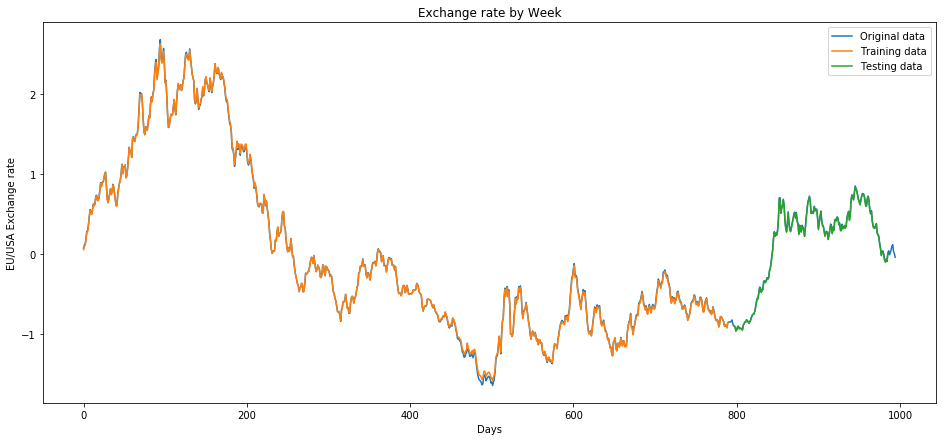

In [98]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Exchange rate by ' + plot_period)
plt.xlabel('Days')
plt.ylabel('EU/USA Exchange rate')
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
# plt.plot(rate_change_to_use, label='Rate changes in %', color='y')
plt.legend()
plt.show()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000194D8D17CF8>]],
      dtype=object)

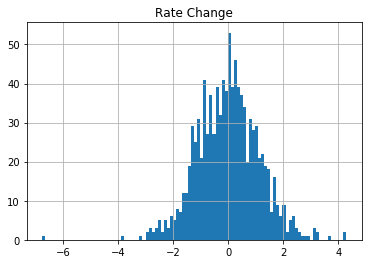

In [118]:
ratechanges=rate_change_df['Rate Change'].values
rate_change_df.hist(bins=100)

In [102]:
rate_change_df

,Rate Change
Year,
1999,0.000000
1999,0.636321
1999,0.220137
1999,0.938849
1999,1.443374
1999,0.083637
1999,1.089405
1999,1.486201
1999,1.250653


In [83]:
y_new_inverse = scaler.inverse_transform(y[len(y)-1])

In [84]:
y_new_inverse

array([0.8396])

In [85]:
tests_new[len(tests_new)-1]

array([0.28569424], dtype=float32)

In [86]:
test_new_inverse = scaler.inverse_transform(tests_new[len(tests_new)-1])

In [87]:
test_new_inverse

array([[0.8837593]], dtype=float32)